
# ✈️ AeroConnect Route Analytics & Forecasting

**Author:** Data Science Student  
**Date:** August 22, 2025

This notebook explores international route performance for AeroConnect and builds a short-term passenger forecast for selected routes.

## Objectives
1. **Understand the data**
   - Identify highest and lowest trafficked routes
   - Analyze trends and geographical patterns (ports, countries, seasonality)
2. **Build models**
   - Compare classic models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting)
   - Forecast passenger traffic for the next 6–12 months on at least one city pair
3. **Evaluate & recommend**
   - Explain model choices and report accuracy
   - Provide route/network recommendations and how to use the model going forward


## 1) Imports & Configuration

In [91]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 2) Load Data

In [92]:

dataPath = 'csv.csv'  # path to uploaded CSV
df = pd.read_csv(dataPath)
df.head()


,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.17,0.31,985,18.70,0.92,2498,60.87,1.24,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.00,0.00,5,0.03,0.00,17,0.03,0.00,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.00,0.00,5,0.00,0.00,12,0.00,0.00,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.01,0.00,171,0.00,0.25,286,0.01,0.25,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.80,0.00,1472,10.62,2.49,3039,13.42,2.49,1985,1


## 3) Initial Inspection

In [93]:

print(df.dtypes)
print("Duplicates:", df.duplicated().sum())
df.describe()


Month                      object
AustralianPort             object
ForeignPort                object
Country                    object
Passengers_In               int64
Freight_In_(tonnes)       float64
Mail_In_(tonnes)          float64
Passengers_Out              int64
Freight_Out_(tonnes)      float64
Mail_Out_(tonnes)         float64
Passengers_Total            int64
Freight_Total_(tonnes)    float64
Mail_Total_(tonnes)       float64
Year                        int64
Month_num                   int64
dtype: object
Duplicates: 0


,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,"9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00"
mean,"1,489.99",57.58,1.33,"1,439.84",66.32,2.07,"2,929.83",123.90,3.39,"1,986.86",6.20
std,"3,101.65",150.50,5.74,"3,065.38",165.84,6.49,"6,130.62",297.55,10.40,1.30,3.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,985.00",1.00
25%,45.00,0.00,0.00,51.00,0.00,0.00,100.00,0.05,0.00,"1,986.00",3.00
50%,333.00,2.12,0.00,324.00,5.20,0.01,664.00,13.10,0.04,"1,987.00",6.00
75%,"1,586.00",41.67,0.22,"1,535.50",58.67,1.06,"3,131.50",93.72,1.52,"1,988.00",9.00
max,"37,754.00","1,795.48",110.52,"38,475.00","1,899.03",103.11,"70,014.00","3,242.98",197.70,"1,989.00",12.00


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

## 4) Cleaning & Feature Engineering

In [95]:

# Route column
df['route'] = df['AustralianPort'].str.strip().str.title() + ' - ' + df['ForeignPort'].str.strip().str.title()

# Standardize text columns
for col in ['AustralianPort','ForeignPort','Country']:
    df[col] = df[col].astype(str).str.strip().str.title()

# Create date field
df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str), format='%Y-%m')

df.drop('Month',axis =1,inplace= True)

In [96]:
df = df[['date','Year','Month_num','route','AustralianPort','ForeignPort','Country','Passengers_In','Passengers_Out','Passengers_Total','Freight_In_(tonnes)','Freight_Out_(tonnes)','Freight_Total_(tonnes)','Mail_In_(tonnes)','Mail_Out_(tonnes)', 'Mail_Total_(tonnes)']]

In [97]:
df.head(5)

,date,Year,Month_num,route,AustralianPort,ForeignPort,Country,Passengers_In,Passengers_Out,Passengers_Total,Freight_In_(tonnes),Freight_Out_(tonnes),Freight_Total_(tonnes),Mail_In_(tonnes),Mail_Out_(tonnes),Mail_Total_(tonnes)
0,1985-01-01,1985,1,Adelaide - Auckland,Adelaide,Auckland,New Zealand,1513,985,2498,42.17,18.70,60.87,0.31,0.92,1.24
1,1985-01-01,1985,1,Adelaide - Bahrain,Adelaide,Bahrain,Bahrain,12,5,17,0.00,0.03,0.03,0.00,0.00,0.00
2,1985-01-01,1985,1,Adelaide - Bombay,Adelaide,Bombay,India,7,5,12,0.00,0.00,0.00,0.00,0.00,0.00
3,1985-01-01,1985,1,Adelaide - Frankfurt,Adelaide,Frankfurt,Germany,115,171,286,0.01,0.00,0.01,0.00,0.25,0.25
4,1985-01-01,1985,1,Adelaide - London,Adelaide,London,Uk,1567,1472,3039,2.80,10.62,13.42,0.00,2.49,2.49


In [98]:
invalid_passenger_rows = df[(df['Passengers_Total'] <= 0) | 
                            (df['Passengers_In'] < 0) | 
                            (df['Passengers_Out'] < 0)]

print(f"Invalid passenger rows: {len(invalid_passenger_rows)}")

Invalid passenger rows: 44


Top 10 Routes:
 route
Sydney - Auckland        2961212
Sydney - Singapore       1440018
Sydney - Tokyo           1292116
Sydney - Hong Kong       1151900
Perth - Singapore         952926
Brisbane - Auckland       893246
Sydney - Christchurch     882357
Melbourne - Singapore     865251
Sydney - Los Angeles      862964
Sydney - Honolulu         861814
Name: Passengers_Total, dtype: int64

Bottom 10 Routes:
 route
Hobart - Los Angeles           2
Hobart - Tokyo                 1
Cairns - Honiara               1
Townsville - San Francisco     1
Darwin - Zagreb                1
Melbourne - Denver             0
Perth - Bandar Seri Begawan    0
Brisbane - Colombo             0
Adelaide - Harare              0
Brisbane - Chicago             0
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/29086086.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette='viridis')


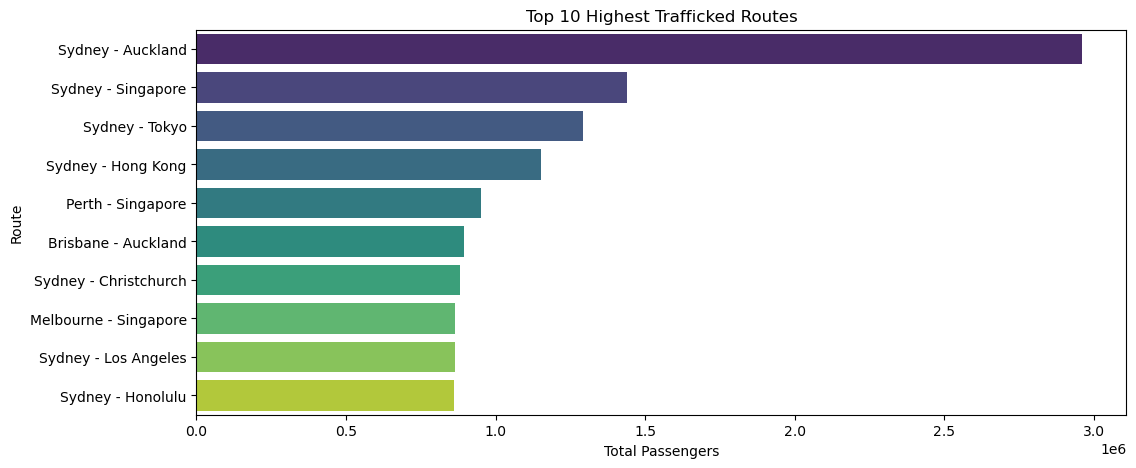

In [99]:
route_traffic = df.groupby('route')['Passengers_Total'].sum().sort_values(ascending=False)

# Top and bottom 10 routes
top_routes = route_traffic.head(10)
route_traffic

print("Top 10 Routes:\n", top_routes)
print("\nBottom 10 Routes:\n", bottom_routes)

# Plotting
plt.figure(figsize=(12,5))
sns.barplot(x=top_routes.values, y=top_routes.index, palette='viridis')
plt.title("Top 10 Highest Trafficked Routes")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()

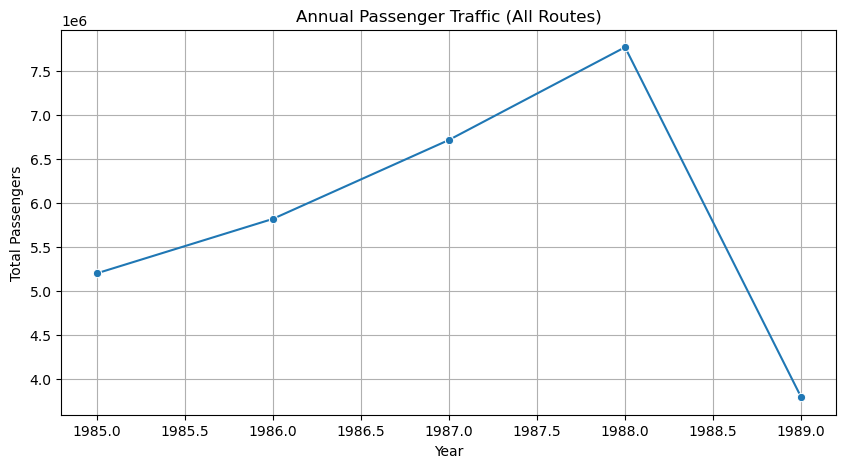

In [100]:
annual_traffic = df.groupby('Year')['Passengers_Total'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=annual_traffic.index, y=annual_traffic.values, marker='o')
plt.title("Annual Passenger Traffic (All Routes)")
plt.ylabel("Total Passengers")
plt.xlabel("Year")
plt.grid(True)
plt.show()

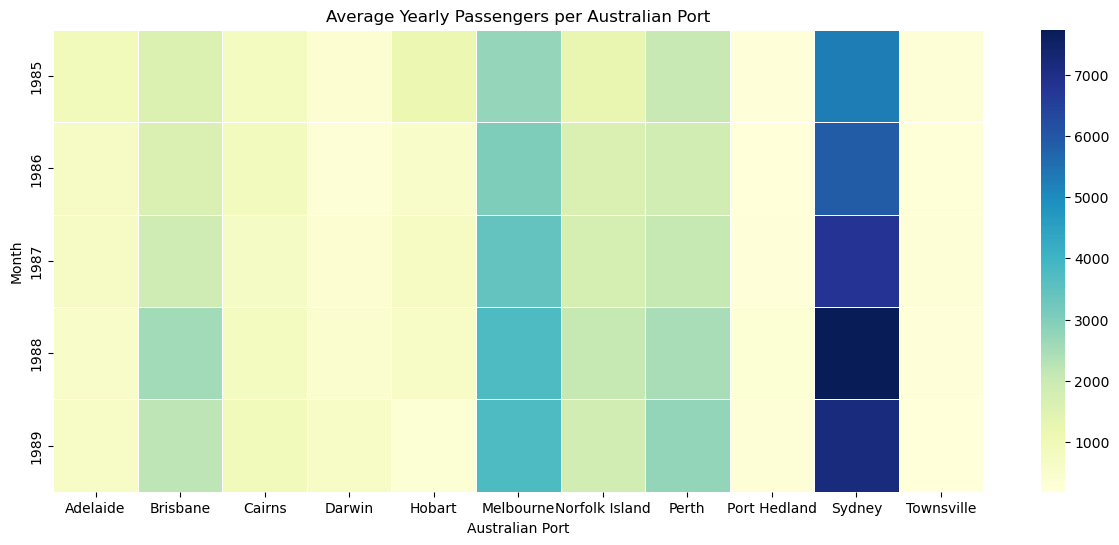

In [101]:
yearly_avg = df.groupby(['Year', 'AustralianPort'])['Passengers_Total'].mean().unstack()
plt.figure(figsize=(15,6))
sns.heatmap(yearly_avg, cmap="YlGnBu", linewidths=0.5)
plt.title("Average Yearly Passengers per Australian Port")
plt.xlabel("Australian Port")
plt.ylabel("Month")
plt.show()

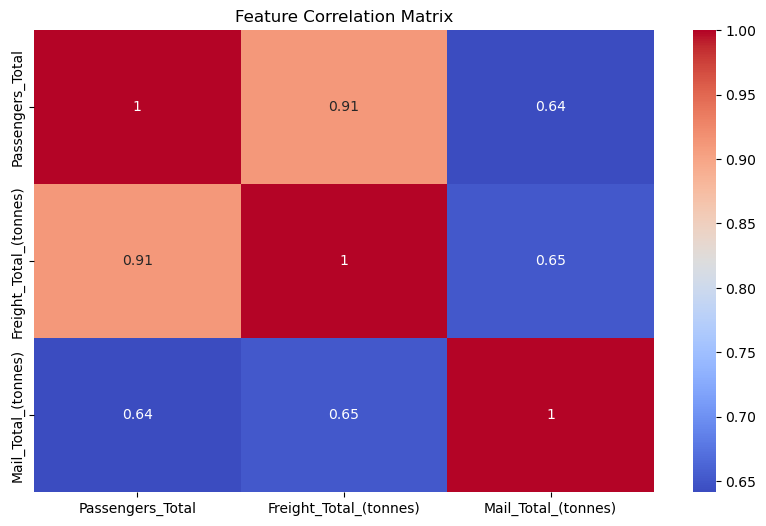

In [102]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

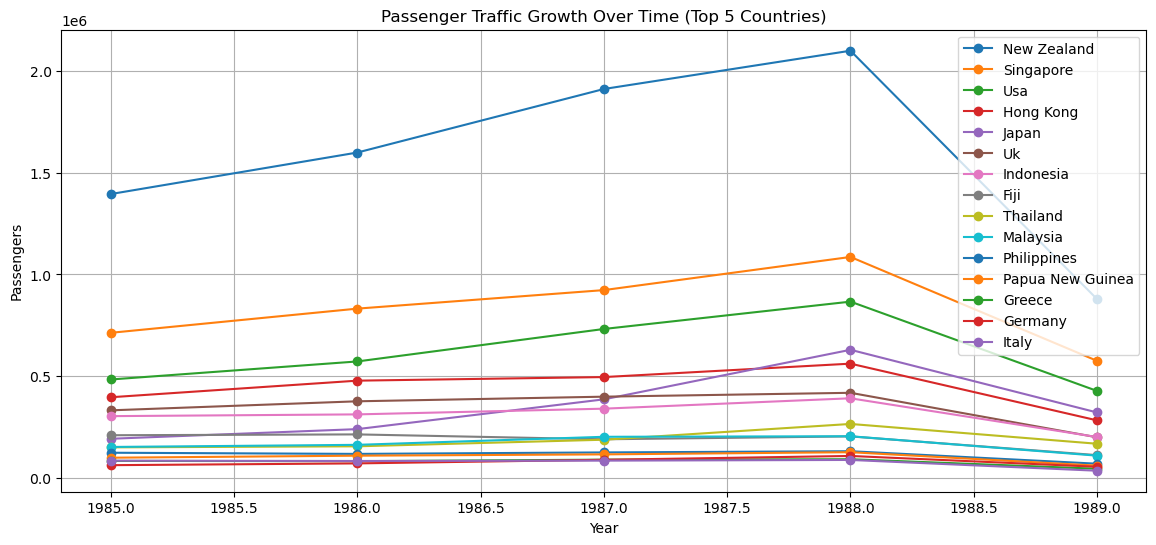

In [103]:
country_year = df.groupby(['Year','Country'])['Passengers_Total'].sum().reset_index()
country_traffic = df.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14,6))
top_countries = country_traffic.index[:]  # top 5 countries
for c in country_traffic.index:
    subset = country_year[country_year['Country'] == c]
    plt.plot(subset['Year'], subset['Passengers_Total'], marker='o', label=c)

plt.title("Passenger Traffic Growth Over Time (Top 5 Countries)")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/3995281796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")


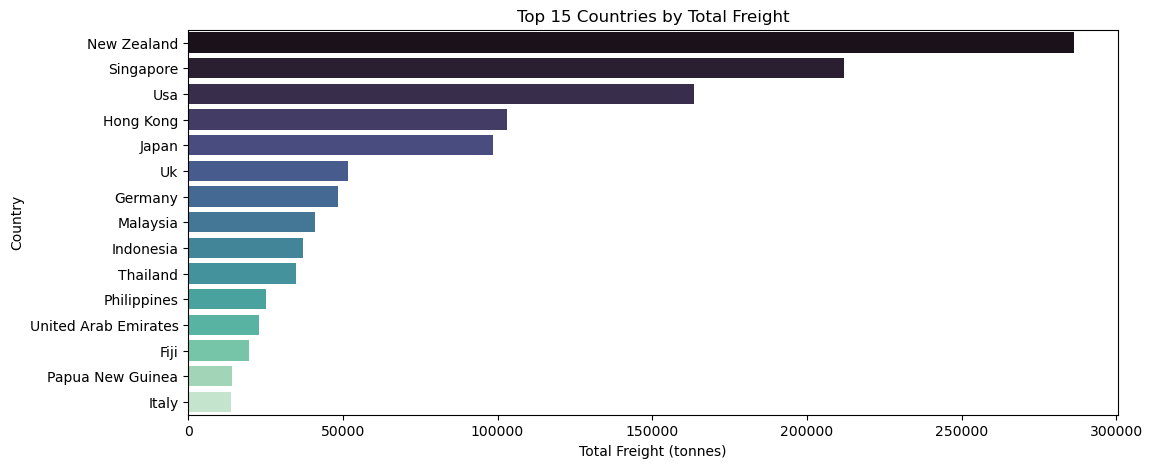

In [104]:
country_freight = df.groupby('Country')['Freight_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")
plt.title("Top 15 Countries by Total Freight")
plt.xlabel("Total Freight (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/1317873066.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")


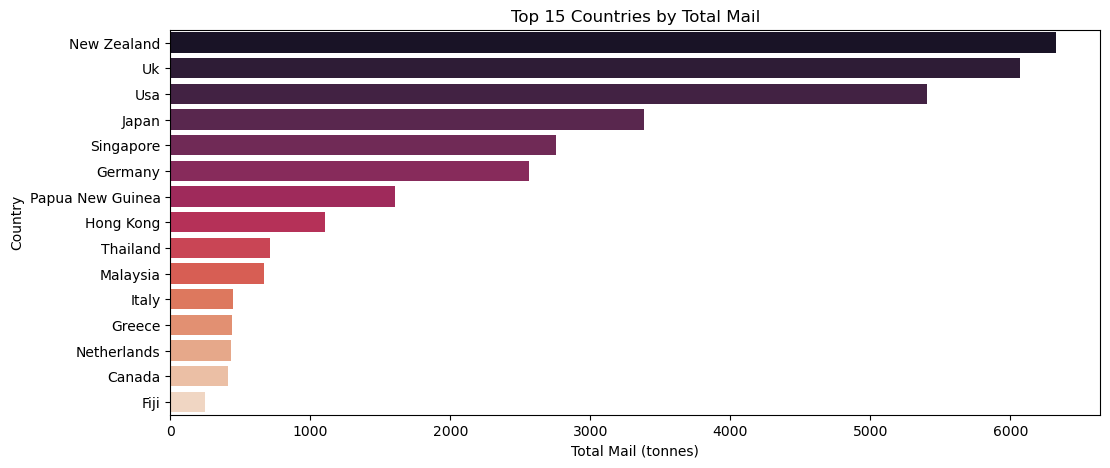

In [105]:
# --- 3. Mail by Country ---
country_mail = df.groupby('Country')['Mail_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")
plt.title("Top 15 Countries by Total Mail")
plt.xlabel("Total Mail (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/766701626.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")


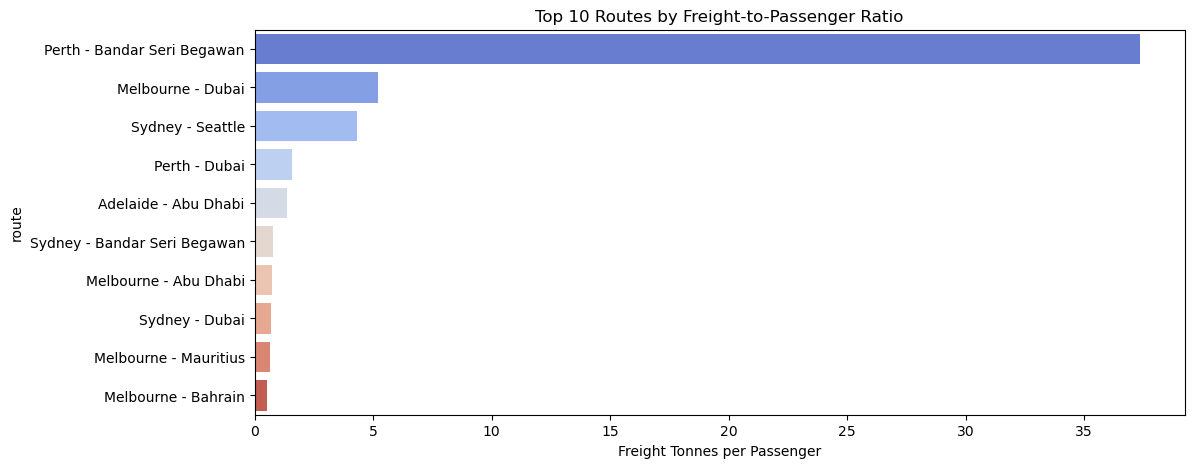

In [106]:
# --- 4. Freight to Passenger Ratio ---
df['Freight_per_Passenger'] = df['Freight_Total_(tonnes)'] / (df['Passengers_Total']+1)  # avoid div by 0
ratio = df.groupby('route')['Freight_per_Passenger'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")
plt.title("Top 10 Routes by Freight-to-Passenger Ratio")
plt.xlabel("Freight Tonnes per Passenger")
plt.show()

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [108]:
X= 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

SyntaxError: invalid syntax (2542852502.py, line 1)

In [ ]:
df.to_csv('df.csv')
